# Assess Sensitivity & Overlap with RIC studies

In [1]:
import pandas as pd
import numpy as np
import mygene
import Bio.SeqIO as sio
import matplotlib_venn
import matplotlib.pyplot as plt
import seaborn
plt.rc('font', family='Times New Roman')
%matplotlib inline

In [2]:
# PARAMETERS
tripepsvm_optimal = 0.68 # from figure 2

## 1. Load proteomewide prediction of TriPepSVM (on human proteome)

In [3]:
protwide_tripepsvm_human = pd.read_csv('../data/proteome_prediction_human/proteome_9606.TriPepSVM.pred.txt',
                                       sep='\t', header=None, names=['Uniprot_ID', 'Score', 'Class'])
protwide_tripepsvm_human['Uniprot_ID'] = [n.split('|')[1].strip() for n in protwide_tripepsvm_human.Uniprot_ID]
no_total_pred = protwide_tripepsvm_human[protwide_tripepsvm_human.Score >= tripepsvm_optimal].shape[0]
tripep_protwide_pred = protwide_tripepsvm_human[protwide_tripepsvm_human.Score >= tripepsvm_optimal]
print ("TriPepSVM predicts {} RBPs in Human".format(no_total_pred))

TriPepSVM predicts 2944 RBPs in Human


## 2. Get Uniprot IDs for all independent studies
For that, we have to load the csv files (derived from tables in the supplementaries of each paper) and map the IDs using the _MyGene_ service.

In [4]:
beck = pd.read_csv('../data/RIC_studies/rna_binding_proteomes_from_yeast_to_man_human_interactome.csv')
beck_uniprot_ids = list(set(beck.Uniprot))
print ("Beckmann paper validates {} RBPs".format(len(beck_uniprot_ids)))

Beckmann paper validates 783 RBPs


In [5]:
conrad = pd.read_csv('../data/RIC_studies/serial_interactome_capture_of_the_human_cell_nucleus.csv', header=1)
def get_uniprot_id(gene):
    if not 'uniprot' in gene:
        print ("No uniprot ID found for {}".format(gene['query']))
        return None
    else:
        if not 'Swiss-Prot' in gene['uniprot']:
            print ("No Swiss-Prot ID for {}".format(gene['query']))
            return None
        if type(gene['uniprot']['Swiss-Prot']) is list:
            return gene['uniprot']['Swiss-Prot'][0]
        else:
            return gene['uniprot']['Swiss-Prot']

mg = mygene.MyGeneInfo()
conrad_ens_IDs = list(set(list(conrad[~conrad.ID.isnull()].ID) + list(conrad[~conrad['ID.1'].isnull()]['ID.1'])))
res = mg.querymany(conrad_ens_IDs, scopes='ensemblgene', fields='uniprot', species='human')
conrad_uniprot_ids = [get_uniprot_id(gene) for gene in res]
print ("Conrad paper validates {} RBPs".format(len(conrad_uniprot_ids)))

querying 1-382...done.
Finished.
19 input query terms found no hit:
	['ENSG00000268489', 'ENSG00000185554', 'ENSG00000263344', 'ENSG00000268226', 'ENSG00000268612', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
No uniprot ID found for ENSG00000268489
No uniprot ID found for ENSG00000185554
No uniprot ID found for ENSG00000263344
No uniprot ID found for ENSG00000268226
No uniprot ID found for ENSG00000268612
No uniprot ID found for ENSG00000215699
No uniprot ID found for ENSG00000260501
No uniprot ID found for ENSG00000261493
No uniprot ID found for ENSG00000260485
No uniprot ID found for ENSG00000263977
No uniprot ID found for ENSG00000141141
No uniprot ID found for ENSG00000172660
No uniprot ID found for ENSG00000261932
No uniprot ID found for ENSG00000263077
No uniprot ID found for ENSG00000177764
No uniprot ID found for ENSG00000261306
No uniprot ID found for ENSG00000268642
No uniprot ID found for ENSG00000262589
No uniprot ID found for EN

In [6]:
hentze = pd.read_csv('../data/RIC_studies/brave_new_rbp_world_human_rbps.csv', sep='\t')
hentze = hentze.iloc[1:, :] # remove row with study names

hentze_ens_IDs = [i[0] for i in hentze.ID.str.split(';')]
res = mg.querymany(hentze_ens_IDs, scopes='ensemblgene', fields='uniprot', species='human')
hentze_uniprot_ids = [get_uniprot_id(gene) for gene in res]
print ("Hentze paper validates {} RBPs".format(len(hentze_uniprot_ids)))

querying 1-1000...done.
querying 1001-1393...done.
Finished.
No uniprot ID found for ENSG00000188004
No Swiss-Prot ID for ENSG00000277936
No Swiss-Prot ID for ENSG00000271425
No uniprot ID found for ENSG00000254535
No Swiss-Prot ID for ENSG00000100101
No Swiss-Prot ID for ENSG00000215472
Hentze paper validates 1393 RBPs


In [7]:
baltz = pd.read_csv('../data/RIC_studies/the_mrna_bound_proteome_and_its_global_occupancy_profile.csv', header=1)
baltz_refseq_ids = baltz.RefSeq
res = mg.querymany(baltz_refseq_ids, scopes='refseq', fields='uniprot', species='human')
baltz_uniprot_ids = [get_uniprot_id(gene) for gene in res]
print ("Baltz paper validates {} RBPs".format(len(baltz_uniprot_ids)))

querying 1-797...done.
Finished.
1 input query terms found dup hits:
	[('NP_001136113', 2)]
3 input query terms found no hit:
	['NP_277028', 'NP_849152', 'NP_001127705']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
No uniprot ID found for NP_001108206
No Swiss-Prot ID for NP_115727
No uniprot ID found for NP_277028
No uniprot ID found for NP_849152
No uniprot ID found for NP_001127705
No Swiss-Prot ID for NP_001034792
Baltz paper validates 797 RBPs


## 3. Compute Sensitivity of each study with our predictions

In [8]:
def get_sensitivity(protwide_pred, rbp_ids, cutoff):
    ids_present = protwide_pred[protwide_pred.Uniprot_ID.isin(rbp_ids)].Uniprot_ID
    pos_protwide_pred = protwide_pred[protwide_pred.Score >= cutoff]
    no_tp = pos_protwide_pred[pos_protwide_pred.Uniprot_ID.isin(rbp_ids)].shape[0]
    return no_tp, ids_present, no_tp / ids_present.shape[0]

beck_overlap, beck_valid_ids, beck_sens = get_sensitivity(protwide_tripepsvm_human, beck_uniprot_ids, tripepsvm_optimal)
conrad_overlap, conrad_valid_ids, conrad_sens = get_sensitivity(protwide_tripepsvm_human, conrad_uniprot_ids, tripepsvm_optimal)
baltz_overlap, baltz_valid_ids, baltz_sens = get_sensitivity(protwide_tripepsvm_human, baltz_uniprot_ids, tripepsvm_optimal)
hentze_overlap, hentze_valid_ids, hentze_sens = get_sensitivity(protwide_tripepsvm_human, hentze_uniprot_ids, tripepsvm_optimal)

In [9]:
print ("Overlap between OligoPepSVM predictions and Validations:")
print ("Beckmann et al.: Overlap: {}\tStudy Size: {}\tSensitivity: {}".format(beck_overlap, beck_valid_ids.shape[0], beck_sens))
print ("Conrad et al.: Overlap: {}\tStudy Size: {}\tSensitivity: {}".format(conrad_overlap, conrad_valid_ids.shape[0], conrad_sens))
print ("Baltz et al.: Overlap: {}\tStudy Size: {}\tSensitivity: {}".format(baltz_overlap, baltz_valid_ids.shape[0], baltz_sens))
print ("Hentze et al.: Overlap: {}\tStudy Size: {}\tSensitivity: {}".format(hentze_overlap, hentze_valid_ids.shape[0], hentze_sens))

Overlap between OligoPepSVM predictions and Validations:
Beckmann et al.: Overlap: 668	Study Size: 782	Sensitivity: 0.8542199488491049
Conrad et al.: Overlap: 329	Study Size: 362	Sensitivity: 0.9088397790055248
Baltz et al.: Overlap: 727	Study Size: 789	Sensitivity: 0.9214195183776933
Hentze et al.: Overlap: 1068	Study Size: 1377	Sensitivity: 0.775599128540305


## 4. Compute and visualize the overlap between RIC studies, Pfam domains & our predictions

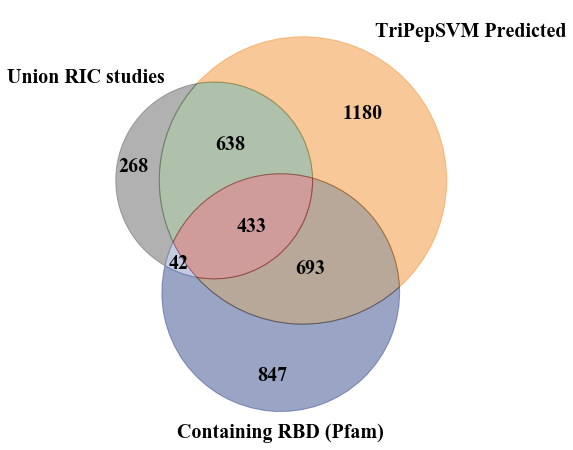

In [12]:
prots_with_pfam = pd.read_csv('../data/pfam_domains_proteome/9606.Pfam_HMMER.pred.proteome.txt', sep='\t', header=None, names=['Uniprot'])
all_validated = list(set(pd.concat((beck_valid_ids, conrad_valid_ids, baltz_valid_ids, hentze_valid_ids))))

fig = plt.figure(figsize=(14, 8))
v = matplotlib_venn.venn3([set(all_validated), set(tripep_protwide_pred.Uniprot_ID), set(prots_with_pfam.Uniprot)],
          set_labels=['Union RIC studies', 'TriPepSVM Predicted', 'Containing RBD (Pfam)'])
v.get_patch_by_id('10').set_color('#3d3e3d')
v.get_patch_by_id('11').set_color('#37652d')
v.get_patch_by_id('01').set_color('#ee7600')
v.get_patch_by_id('111').set_color('#890707')
v.get_patch_by_id('101').set_color('#6E80B7')
v.get_patch_by_id('011').set_color('#4d2600')
v.get_patch_by_id('001').set_color('#031F6F')
v.get_label_by_id('A').set_fontsize(20)
v.get_label_by_id('B').set_fontsize(20)
v.get_label_by_id('C').set_fontsize(20)
v.get_label_by_id('10').set_fontsize(20)
v.get_label_by_id('11').set_fontsize(20)
v.get_label_by_id('01').set_fontsize(20)
v.get_label_by_id('111').set_fontsize(20)
v.get_label_by_id('101').set_fontsize(20)
v.get_label_by_id('011').set_fontsize(20)
v.get_label_by_id('001').set_fontsize(20)
fig.savefig('overlap_all_studies_oligo_pfam.svg')

## 5. Derive annotated list of all proteins

In [14]:
mg = mygene.MyGeneInfo()
res = mg.querymany(protwide_tripepsvm_human.Uniprot_ID, scopes='uniprot', fields='symbol', species='human')

def get_symbol_from_res(r):
    if 'symbol' in r:
        return [r['query'], r['symbol']]
    else:
        return [r['query'], np.nan]

map_list = [get_symbol_from_res(i) for i in res]
mapping = pd.DataFrame(map_list, columns=['Uniprot', 'Symbol']).set_index('Uniprot')
mapping = mapping[~mapping.index.duplicated()]
proteome_withnames = protwide_tripepsvm_human.set_index('Uniprot_ID').join(mapping)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-20410...done.
Finished.
332 input query terms found dup hits:
	[('Q8NG57', 2), ('P0DPD8', 2), ('P0DPD6', 2), ('A0A0C4DH41', 2), ('A0A0C4DH38', 2), ('A0A0B4J1U7', 2
1124 input query terms found no hit:
	['Q9N2K0', 'O42043', 'P61566', 'Q9HDB8', 'A0A087WX78', 'B3EWF7', 'Q9NRJ2', 'Q902F9', 'P0CJ85', 'Q658
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [15]:
# change column order to prepare for additional columns
proteome_withnames.columns = ['TriPepSVM Score', 'TriPepSVM Prediction', 'Symbol']
cols = proteome_withnames.columns.tolist()
proteome_withnames = proteome_withnames[[cols[-1]] + cols[:-1]]

# add IC study column
proteome_withnames['In IC study'] = False
proteome_withnames.loc[proteome_withnames.index.isin(all_validated), 'In IC study'] = True

# add Pfam column
proteome_withnames['Contains Pfam Domain'] = False
proteome_withnames.loc[proteome_withnames.index.isin(prots_with_pfam.Uniprot), 'Contains Pfam Domain'] = True

In [17]:
proteome_withnames.sort_values(by='TriPepSVM Score', ascending=False).to_csv('venn_diagram_fig3_table.tsv', sep='\t')